# Experimental feature: Content classification with confidence scores
Rami Ariss, April 13th 2022

Google Cloud Natural Language API has a content classification feature that, given text, returns content categories with their confidence rankings.

My hypothesis is that limericks with high subject continuity should have content classification categories with high confidence. This notebook implements the Google Natural Language API to classify limericks.

NOTE: This requires setting up a Google Cloud billing account, and the service is NOT free after the first 30k content classification API hits.

Resources:
- [Google Natural Language: Classify text tutorial](https://cloud.google.com/natural-language/docs/classify-text-tutorial)
- [Google Natural Language Pricing](https://cloud.google.com/natural-language/pricing)

# Notebook Preparation

In [ ]:
!pip install --upgrade google-cloud-language

In [ ]:
import argparse
import io
import json
import os

from google.cloud import language
import numpy
import six
import pandas as pd
import numpy as np
import scipy
import time

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import RegexpTokenizer

In [ ]:
# Replace path with the path of the JSON file that contains your service account key.
credential_fpath = '/content/automatic-poetry-generation-85e59269832f.json'
!gcloud auth activate-service-account --key-file $credential_fpath
!pip install --upgrade -q google-cloud-vision

In [ ]:
%env GOOGLE_APPLICATION_CREDENTIALS=$credential_fpath

# Data

Limerick files can be found under `/data/raw` in the github repository. I have this mounted in my Google Drive as well.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
DATA_DIR = 'drive/MyDrive/11-785_IDL/automatic_poetry_generation/data'
!ls $DATA_DIR

In [ ]:
def json_poems(fname):
  """Cleans up poems in the parsed jsons format into a list of strings"""
  f = open(fname)
  poems_json = json.load(f)
  
  poems = []
  for k, p in poems_json['limericks'].items():
    poems.append(p['lines'])

  return poems_json, poems

In [ ]:
def generated_poems_json(fname):
  """Reads in generated poems into a list of strings"""
  # load_json
  with open(fname) as f:
    poems = json.load(f)

  return poems

In [ ]:
def generated_poems(fname):
  """Cleans up generated poems and into a list of strings"""
  # read file
  with open(fname) as f:
    lines = f.readlines()
  
  # parse into list of poems
  poems = [[]]
  i = 0  # limerick index
  for l in lines:
    l = l.strip()  # remove '\n'
    # if empty line (new limerick)
    if len(l) == 0:
      poems.append([])
      i += 1
    else:
      poems[i].append(l)
  poems = poems[:-1] # exclude last blank

  return poems

## Load OEDILF Limericks

In [ ]:
# Read in raw oedilf poems
oedilf_fpath = os.path.join(DATA_DIR, 'preprocessing/limericks.json')
oedilf_poems_json, oedilf_poems = json_poems(oedilf_fpath)

In [ ]:
# Read in oedilf poems with lexical diversity calculations
oedilf_fpath = os.path.join(DATA_DIR, 'raw/oedilf_lexical_diversity.json')
oedilf_poems = generated_poems_json(oedilf_fpath)

# Load Filtered Generated Free Form Poems

In [ ]:
# Read in free form generated poems with lexical diversity calculations
filtered_free_form_fpath = os.path.join(DATA_DIR, 'raw/04_21_free_form_spell_checked_12832_ld_10702.json')
filtered_free_form_poems = generated_poems_json(filtered_free_form_fpath)

# Content Classification
Run batch content classification using Googles Natural Language content classification API.

WARNING: Check Google Pricing before running on large datasets ($2/1k queries at time of run)

In [ ]:
def classify(text, verbose=True):
    """Classify the input text into categories."""

    language_client = language.LanguageServiceClient()

    document = language.Document(
        content=text, type_=language.Document.Type.PLAIN_TEXT
    )
    response = language_client.classify_text(request={"document": document})
    print(response)
    categories = response.categories

    result = {}

    for category in categories:
        # Turn the categories into a dictionary of the form:
        # {category.name: category.confidence}, so that they can
        # be treated as a sparse vector.
        result[category.name] = category.confidence

    if verbose:
        print(text)
        for category in categories:
            print("=" * 20)
            print("{:<16}: {}".format("category", category.name))
            print("{:<16}: {}".format("confidence", category.confidence))

    return result

In [ ]:
def classify_poems(poems, verbose=False, check_freq=100):
  "Classify a list of poems into categories"

  language_client = language.LanguageServiceClient()

  # flatten the poems into a single line each
  if isinstance(poems, list):
    flat_poems = list(map(lambda p: ' '.join(p), poems)) # classification seems better without punctuation
  else:
    print('ERROR: POEMS MUST BE OF TYPE LIST')

  results = []
  for i, text in enumerate(flat_poems):
    if (i % (check_freq)-1) == 0:
      print(f'Classifying poem {i}')
   
    document = language.Document(
        content=text, type_=language.Document.Type.PLAIN_TEXT
    )
    
    result = {}
    try:
      response = language_client.classify_text(request={"document": document})
      categories = response.categories

      for category in categories:
          # Turn the categories into a dictionary of the form:
          # {category.name: category.confidence}, so that they can
          # be treated as a sparse vector.
          result[category.name] = category.confidence

      if verbose:
          print(text)
          for category in categories:
              print("=" * 20)
              print("{:<16}: {}".format("category", category.name))
              print("{:<16}: {}".format("confidence", category.confidence))
    except:
      print(f'ERROR poem {i}: {text}')
    
    results.append(result)

  return flat_poems, results

In [ ]:
def classify_poems_dict(poems, verbose=False, check_freq=100, max_tries=5, pause_length=2):
  "Classify a list of poems into categories"

  language_client = language.LanguageServiceClient()

  results = {}
  for i, (k, v) in enumerate(poems.items()):
    text = v['poem']
    if ((i+1) % check_freq) == 0:
      print(f'Classifying poem {i}')
   
    document = language.Document(
        content=' '.join(text), type_=language.Document.Type.PLAIN_TEXT
    )  # pass in flattened poem with no punctuation
    
    result = None
    for t in range(max_tries):
        pause = t * pause_length
        try:
          time.sleep(pause) 
          response = language_client.classify_text(request={"document": document})
          categories = response.categories
          result = {}
          for category in categories:
              # Turn the categories into a dictionary of the form:
              # {category.name: category.confidence}, so that they can
              # be treated as a sparse vector.
              result[category.name] = category.confidence

          if verbose:
              print('\n'.join(text))
              for category in categories:
                  print("=" * 20)
                  print("{:<16}: {}".format("category", category.name))
                  print("{:<16}: {}".format("confidence", category.confidence))
          break
        except Exception:
          print(i, k, text, Exception)
          continue
    
    # results[k] = {
    #     'poem': '\n'.join(text),
    #     'class': result
    # }
    
    results[k] = v.copy()
    results[k].update({
        'poem': '\n'.join(text),
        'class': result
        })

  return results

In [ ]:
# Run batch content classification on filtered generated free form poems
results = classify_poems_dict(filtered_free_form_poems)

In [ ]:
# Copy results for posterity
classified_free_form_poems = results.copy()

In [ ]:
# combining in lexical diversity results using poem key
for k, v in classified_free_form_poems.items():
  v['lexical_diversity'] = filtered_free_form_poems[k]['lexical_diversity']

In [ ]:
# Get counts for classified, error, and unclassified poems
counts = {
    'classified': 0,
    'unclassified': 0,
    'error': 0
}
for k, v in classified_free_form_poems.items():
  if v['class']:
    counts['classified'] += 1
  elif isinstance(v['class'], dict):
    counts['unclassified'] += 1
  else:
    counts['error'] += 1

In [ ]:
counts

{'classified': 5504, 'error': 6, 'unclassified': 5192}

In [ ]:
# output just the keys, poems with classifications
output = {k: v['poem'] for k, v in results.items() if v['class']}

In [ ]:
# export the classified results to a JSON
output_fpath = os.path.join(DATA_DIR, 'classification/04_21_free_form_spell_checked_12832_ld_10702_class_5504.json')
with open(output_fpath, 'w') as fp:
    json.dump(output, fp)

In [ ]:
# package into dataframe
unpack_classes = {k: v['class'] for k, v in classified_free_form_poems.items()}  # pull out classes into own dict for flattening
classified_free_form_poems_df = pd.concat([pd.DataFrame.from_dict(classified_free_form_poems, orient='index').drop(['class'], axis=1), 
                                           pd.DataFrame.from_dict(unpack_classes).T.astype('float64')], axis=1)

In [ ]:
# save classifications to CSV to reduce API queries in future
classified_free_form_poems_df.to_csv(os.path.join(DATA_DIR, 'classification/04_21_free_form_spell_checked_12832_ld_10702_class_5504.csv'))

In [ ]:
# save final JSON
output_fpath = os.path.join(DATA_DIR, 'classification/04_21_free_form_spell_checked_12832_ld_10702_class_5504_allmetrics.json')
with open(output_fpath, 'w') as fp:
    json.dump(classified_free_form_poems, fp)

# Oedilf Classification (Dict, API throttle)

In [ ]:
# Run batch classification on entire OEDILF dataset
oedilf_results = classify_poems_dict(oedilf_poems, check_freq=1000)

In [ ]:
# save final JSON
output_fpath = os.path.join(DATA_DIR, 'classification/oedilf_ld_class_72432.json')
with open(output_fpath, 'w') as fp:
    json.dump(oedilf_results, fp)

In [ ]:
classified_oedilf_poems = oedilf_results.copy()

In [ ]:
oedilf_counts = {
    'classified': 0,
    'unclassified': 0,
    'error': 0
}
for k, v in classified_oedilf_poems.items():
  if v['class']:
    oedilf_counts['classified'] += 1
  elif isinstance(v['class'], dict):
    oedilf_counts['unclassified'] += 1
  else:
    oedilf_counts['error'] += 1
oedilf_counts

{'classified': 37861, 'error': 75, 'unclassified': 34496}

In [ ]:
# package into dataframe
unpack_oedilf_classes = {k: v['class'] for k, v in classified_oedilf_poems.items()}  # pull out classes into own dict for flattening
classified_oedilf_poems_df = pd.concat([pd.DataFrame.from_dict(classified_oedilf_poems, orient='index').drop(['class'], axis=1), 
                                           pd.DataFrame.from_dict(unpack_oedilf_classes).T.astype('float64')], axis=1)

In [ ]:
# save classifications to CSV to reduce API queries in future
classified_oedilf_poems_df.to_csv(os.path.join(DATA_DIR, 'classification/oedilf_ld_class_72432.csv'))

# Visualizations and Analysis

In [ ]:
# Load results
fpath = os.path.join(DATA_DIR, 'classification/04_21_free_form_spell_checked_12832_ld_10702_class_5504_allmetrics.json')
with open(fpath) as f:
  classified_free_form_poems = json.load(f)

fpath = os.path.join(DATA_DIR, 'classification/oedilf_ld_class_72432.json')
with open(fpath) as f:
  classified_oedilf_poems = json.load(f)

classified_free_form_poems_df = pd.read_csv(os.path.join(DATA_DIR, 'classification/04_21_free_form_spell_checked_12832_ld_10702_class_5504.csv'), index_col=0)
classified_oedilf_poems_df = pd.read_csv(os.path.join(DATA_DIR, 'classification/oedilf_ld_class_72432.csv'), index_col=0)

In [ ]:
# Compare content classification success rates
print(f"Classification success\nFREE FORM: {counts['classified'] / len(classified_free_form_poems) * 100}%\n" + \
      f"OEDILF: {oedilf_counts['classified'] / len(classified_oedilf_poems) * 100}%")

Classification success
FREE FORM: 51.42963931975332%
OEDILF: 52.271095648332235%


In [ ]:
classified_poems_df = classified_oedilf_poems_df
gen_classified_poems_df = classified_free_form_poems_df

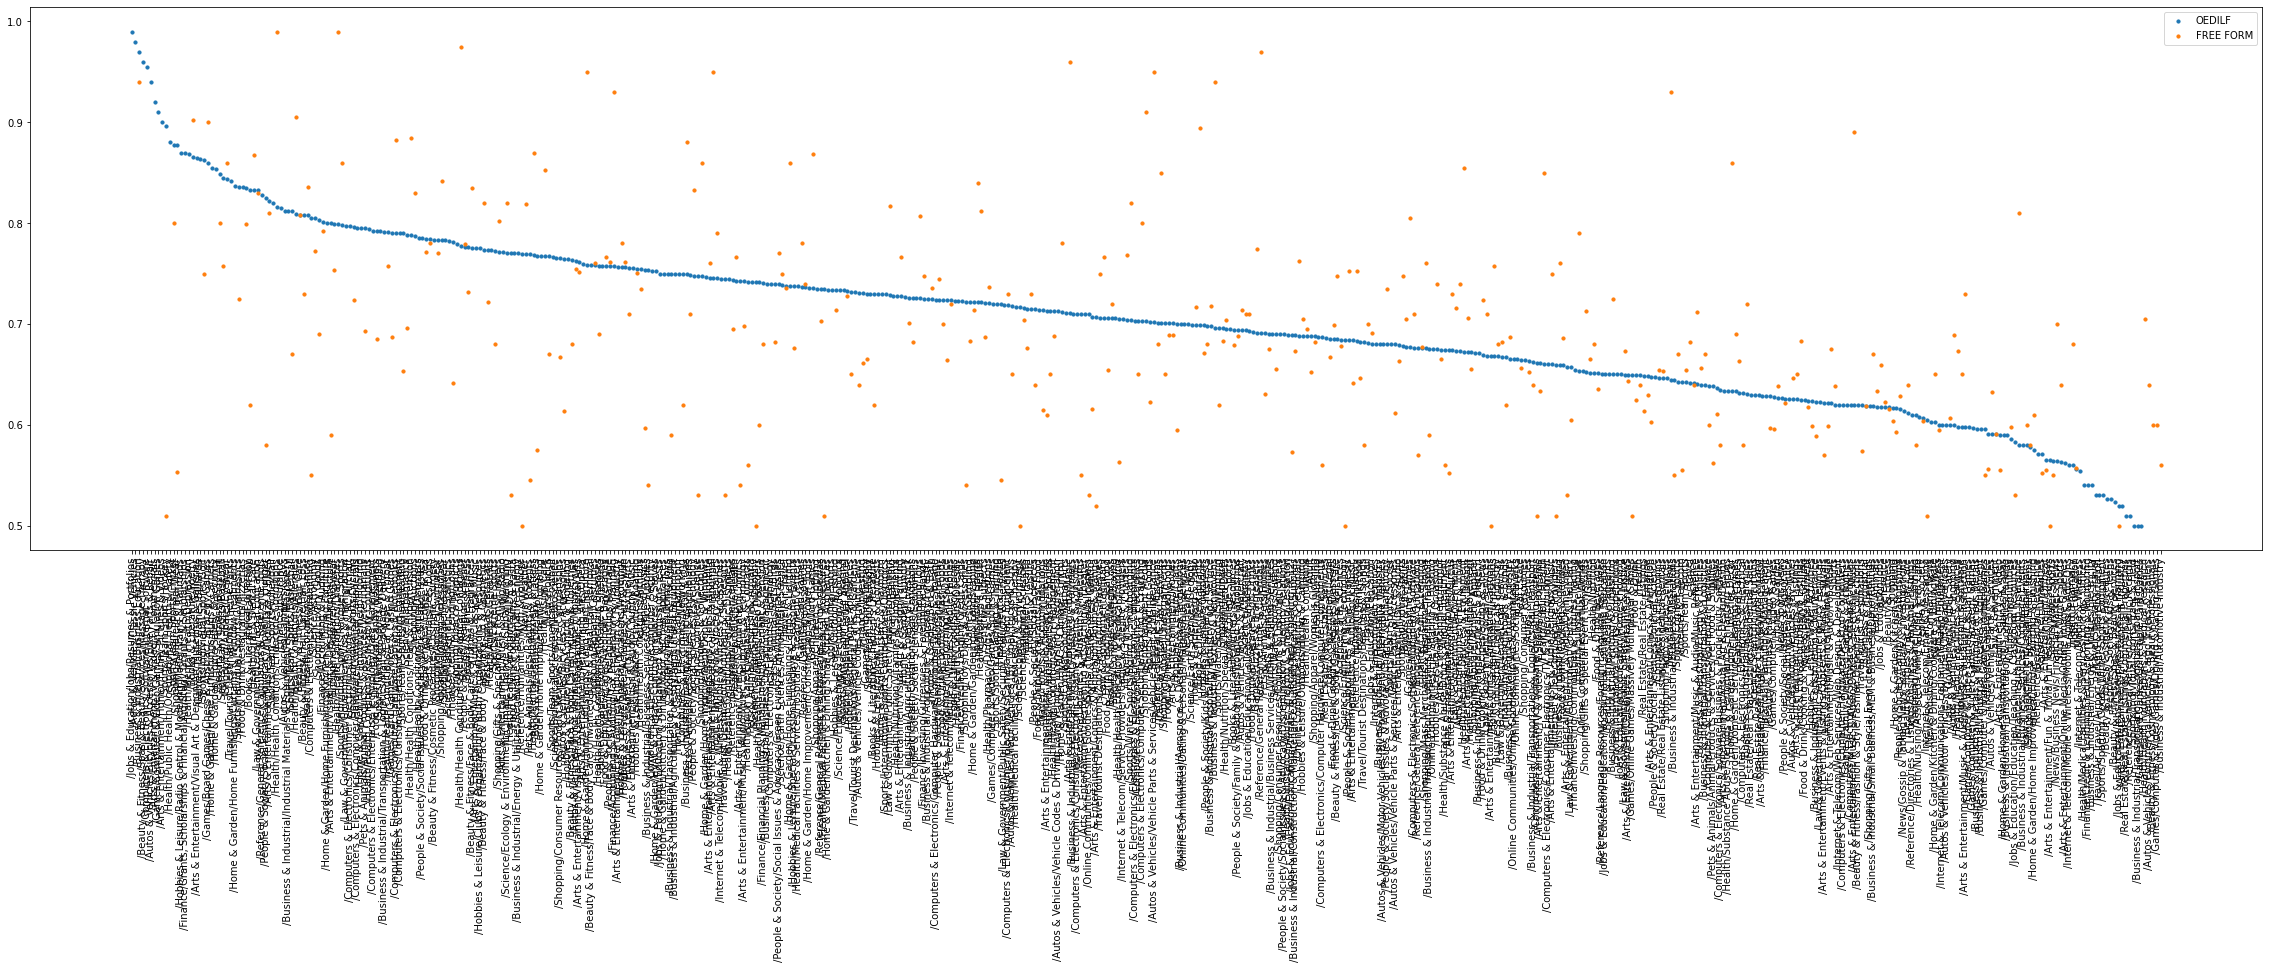

In [ ]:
# Compare classified categories
plt.figure(figsize=(40,10))
plt.scatter(classified_poems_df.describe().loc['mean'].sort_values(ascending=False).index, classified_poems_df.describe().loc['mean'].sort_values(ascending=False), 10)
plt.scatter(gen_classified_poems_df.describe().loc['mean'].sort_values(ascending=False).index, gen_classified_poems_df.describe().loc['mean'].sort_values(ascending=False), 10)
plt.legend(['OEDILF', 'FREE FORM'])
plt.xticks(rotation = 90);

In [ ]:
# Identify categories and limericks in Free Form dataset but not OEDILF
free_form_cats = classified_free_form_poems_df.iloc[:, 2:].columns
oedilf_cats = classified_oedilf_poems_df.iloc[:, 2:].columns
print("Free Form Category: Number of Poems (Max confidence)")
for c in free_form_cats:
  if c not in oedilf_cats:
    print(f"{c}: {sum(classified_free_form_poems_df[c]>0)} ({np.max(classified_free_form_poems_df[c])})")

Free Form Category: Number of Poems (Max confidence)
/Business & Industrial/Automotive Industry: 1 (0.5600000023841858)
/Games/Computer & Video Games/Driving & Racing Games: 1 (0.6000000238418579)
/Health/Health Foundations & Medical Research: 2 (0.7799999713897705)
/Beauty & Fitness/Cosmetology & Beauty Professionals: 1 (0.6000000238418579)
/Autos & Vehicles/Commercial Vehicles/Cargo Trucks & Trailers: 1 (0.6399999856948853)


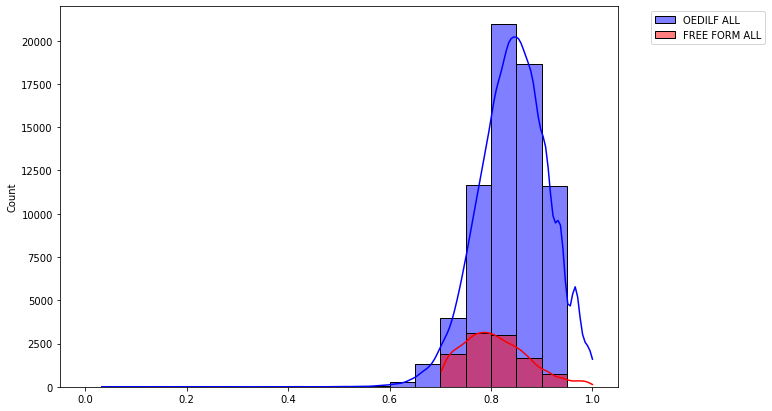

In [ ]:
# Compare distributions of max confidence for classified categories of each limerick in oedilf vs. free form limericks
plt.figure(figsize=(10, 7));
sns.histplot(classified_poems_df.iloc[:, 1:].max(axis=1), bins=np.arange(0,1,.05), label='OEDILF ALL', kde=True, color='blue');
sns.histplot(gen_classified_poems_df.iloc[:, 1:].max(axis=1), bins=np.arange(0,1,.05), label='FREE FORM ALL', kde=True, color='red');
# for c in classified_poems_df.columns[1:]:
#   sns.histplot(classified_poems_df[c], bins=np.arange(0,1,.05), label=c);
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left');

In [ ]:
# Conduct t-test for comparing distributions
scipy.stats.ttest_ind(classified_poems_df.iloc[:, 2:].max(axis=1).dropna(), gen_classified_poems_df.iloc[:, 2:].max(axis=1).dropna(), axis=0, equal_var=False)

Ttest_indResult(statistic=4.44605587864327, pvalue=8.87579227803335e-06)